
# Deep Convolutional Neural Network on CIFAR-10 Dataset

In this project, we explore the implementation of a deep convolutional neural network using Tensorflow 2.5 with the high-level Keras API. We've chosen the CIFAR-10 dataset due to its simplicity, allowing for faster training and experimentation.

## Introduction

The CIFAR-10 dataset is a collection of images spread across 10 different classes. The dataset consists of 60,000 images of size 32x32, split into 50,000 training images and 10,000 test images. The classes include airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.

![CIFAR-10 Image](https://paperswithcode.com/media/datasets/CIFAR-10-0000000431-b71f61c0_U5n3Glr.jpg)

The primary objective of this project is to design, train, and evaluate a deep convolutional neural network on the CIFAR-10 dataset. The steps involved in this process are:
1. Loading the Dataset
2. Data Preprocessing
3. Model Design and Implementation
4. Model Compilation
5. Model Training
6. Model Evaluation



## Architecture Selection & Development Notes

When designing a neural network for image classification, there are various architectural choices to be made. The choice of layers, their sizes, and the number of parameters can greatly affect the performance of the model.

For the CIFAR-10 dataset, given its smaller image size (32 x 32), initial layers with smaller convolution kernels, such as 3 x 3, are preferred. This preserves the spatial dimensions of the input for subsequent layers. As more layers are added, the spatial dimensions typically reduce, while the number of channels in the output feature map increases. The architecture concludes with a global average pooling layer, followed by a fully-connected (dense) layer with softmax activation for the 10 class predictions.


#House Keeping

In [1]:
from __future__ import print_function

%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, SpatialDropout2D,Dropout, RandomFlip, RandomZoom, RandomTranslation
from tensorflow.keras.layers import GlobalAveragePooling2D,AveragePooling2D, Input, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10

import numpy as np

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.



## Dataset Overview

The CIFAR-10 dataset is a collection of 60,000 32x32 color images across 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). Each class contains 6,000 images. The dataset is split into 50,000 training images and 10,000 test images.


In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

# 2. Prepare Data

After importing raw datasets using tfds load, we create an input pipeline that processes & batches this data before it is supplied to the model for training using the virtual machine GPU.

In [2]:
batch_size = 32 # Default Batch size (can be adjusted)
H_trg =32       # Image Height (fixed)
W_trg =32       # image Width (fixed)

# Labels corresponding to categories
label_str = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
# We initally load the raw training/validation/test dataset
import tensorflow_datasets as tfds
ds,info= tfds.load("cifar10",with_info=True)

raw_train = tfds.load('cifar10', split='train[0%:90%]')
raw_val = tfds.load('cifar10', split='train[91%:100%]')
raw_test = tfds.load('cifar10', split='test')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteEROD24/cifar10-train.tfrecord*...:   0%|          | 0/…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteEROD24/cifar10-test.tfrecord*...:   0%|          | 0/1…

Dataset cifar10 downloaded and prepared to ~/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


Plot some examples of the training dataset.

In [4]:

def data_pipe(image,label):
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  image = image-0.5
  label = tf.cast(label, tf.float32)
  return image,label


In [5]:
def gen_tr_datasets(src_dataset):    
    # Define Datasets 
    #src_dataset = src_dataset.shuffle(num_train_examples) 
    tr_dataset = src_dataset.map(lambda x: (x['image'],x['label']))  
    tr_dataset = tr_dataset.map(data_pipe)
    tr_dataset = tr_dataset.batch(batch_size) 
    return tr_dataset

def gen_val_datasets(src_dataset): 
    # Define Datasets 
    test_dataset = src_dataset.map(lambda x: (x['image'],x['label']))  
    test_dataset = test_dataset.map(data_pipe)
    test_dataset = test_dataset.batch(batch_size) 
    return test_dataset
# Generate the datasets
train_dataset = gen_tr_datasets(raw_train)
val_dataset = gen_val_datasets(raw_val)
test_dataset = gen_val_datasets(raw_test)

# 3. Model Coding

In this section You may develop your own model architecture to perform image recognition with the CIFAR-10 Dataset.

There are some recommendations and helper code in this section that you may choose use, or you can also use your own approach to creating your architecture. 

Please Leave a note at the end of the notebook explaining your approach/results for the e-moderator.

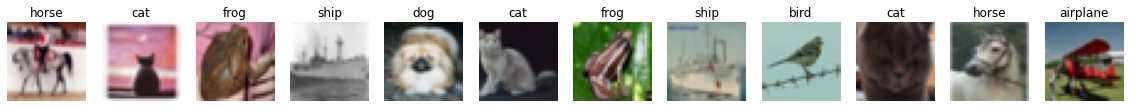

In [6]:
i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(20,10))

for image, label in train_dataset.take(n_plots):  # Only take a single example
  axarr[i].imshow(image[0,:,:,:]+0.5)
  axarr[i].axis('off')
  axarr[i].title.set_text(label_str[int(label[0])])
  i = i+1







 
## Note 1: Keras Function/Sequential API

Within Keras there are two API's for coding network models: Sequential and functional. You may have already used the [seqential model](https://https://www.tensorflow.org/guide/keras/sequential_model) to code basic artifical neural networks. The [functional model](https://www.tensorflow.org/guide/keras/functional) is more general and enables us to include feedforward paths which are required to code more advanced networks such as ResNet or DenseNet. The functional API has been used to code the helper functions repeating unit/top level skeleton detailed below.

## Note 2: Repeating Unit

In many Deep architectures there will often be a repeating unit(s) that is composed of a sequence of layers, for example Conv,ReLU & Batch Normalisation. Specific layers can be turned on or off as required. This also allows experimentation of the entire architecture with/without specific layers (e.g. Batch Normalisation)  You may wish to create other combinations of layers or additional repeating units depending on your architecture.

In the code cell below we can see an example of a `repeat_unit` function where the number of kernel filters and kernel size is specified. Batch Normalisation and activation layers can be turned on/off as required.

 * Convolutional Layers are described [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) 
 * Batch Normalization layers are described [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) 
 * Activation layers are described [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Activation) 
 

## Note 3: Top Level

In the code cell below, an incomplete skeleton function is provided for your top level.  
* This uses the Keras functional API
* A single repeating unit which does not reduce the spatial dimensions of the input is placed at the top of the stack. You can change the number of channels/kernel size to suit your own architecture.
* You can add your own layers/repeating units etc to build your own architecture with the function.
* At the end of the stack we add a [global average pooling layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) and fully connected [(Dense)](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer with softmax activation. (Alternatively to the Global Average pooling Dense layers can be used, this approach uses more parameter (memory) and is commonly seen in earlier Deeep Learning architectures such as AlexNet)

In [19]:
# Example of a Basic Repeating unit

def repeat_unit(inputs, num_channels=16, kernel_size=3,
                 strides=1, activation='relu', batch_normalization=False, spatialDropout=0):
    """
    inputs: Input to repeat unit.
    num_channels: number of channels in convolution layer of repeat unit, nominally = 16
    kernel_size: number of kernels to use in convolution, nominally = 3
    strides: number of strides for kernel, nominally = 1
    activation: type of activation applied to output of convolution, nominally ReLU. 
    x = output of repeat_unit
    """
    conv = Conv2D(num_channels, kernel_size=kernel_size, strides=strides, padding='same',
                  kernel_initializer='he_normal')
    x = conv(inputs)
    
    if activation is not None:
        x = Activation(activation)(x)

    if batch_normalization:
        x = BatchNormalization()(x)

    x = SpatialDropout2D(spatialDropout)(x)

    return x


# 4. Compile the Model
Now that we have defined our functions to create the model, we'll instantiate the model and compile it.  Note that the compiling step in Keras, also configures the model for training. We define  loss function, the optimizer and metrics. 

Note the use here of [Sparse Categorical Crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy). This loss function allows us to input integer values for true classes. With the regular categorical cross entropy loss function the supplied labels must be frist converted to a one-hot representation,  but this special loss function allows us to avoid manually converting to the one-hot representation.


In [25]:

def network_top(input_shape,num_classes=10):
    """
    input Shape: (Define H,W, no. channels) of network input
                 used in Input definition below
    num_classes: Default = 10, sets output classes of network,
                 set to same no. of classes as CIFAR 10 Dataset 
    model:       keras Model returned by this function.                          
    """
       
    # Define input of model
    inputs = Input(shape=input_shape)

    #data augmentation
    x = RandomFlip(mode='horizontal')(inputs)
    x = RandomZoom((-0.2,0.2))(x)
    x = RandomTranslation(height_factor=0.2,width_factor=0.2,fill_mode='nearest')(x)

    # Add First repeating Unit
    x = repeat_unit(inputs=inputs, num_channels=12)
  

   ######## Add more layers/repeating units to build your Architecture here ##################  
    x = repeat_unit(inputs=x, num_channels=48, kernel_size=3, strides=1,  activation='relu', batch_normalization=True, spatialDropout=0.2)
    x = repeat_unit(inputs=x, num_channels=96, kernel_size=3, strides=1,  activation='relu', batch_normalization=True, spatialDropout=0.2)
    x = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
    x = repeat_unit(inputs=x, num_channels=192, kernel_size=3, strides=1,  activation='relu', batch_normalization=True, spatialDropout=0.2)
    x = repeat_unit(inputs=x, num_channels=256, kernel_size=3, strides=1,  activation='relu', batch_normalization=True, spatialDropout=0.2)
    x = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)   
    x = Dense(128, activation='relu')(x)


    # Add final stages. (Ensure that you call the output of the very last layer outputs)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(x)

    # Model definition
    model = Model(inputs=inputs, outputs=outputs)
    return model

# 5. Model Training

We will now train the complied model on the cifar10 dataset using the tensorflow keras `model.fit` method. 



In [26]:
input_shape = (32,32,3)
model = network_top(input_shape=input_shape)
model.compile(loss='SparseCategoricalCrossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

# Uncomment the following line to plot the model visually - warning this may be quite large!
# keras.utils.plot_model(model, dpi=48)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 12)        336       
                                                                 
 activation_13 (Activation)  (None, 32, 32, 12)        0         
                                                                 
 spatial_dropout2d_9 (Spatia  (None, 32, 32, 12)       0         
 lDropout2D)                                                     
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 48)        5232      
                                                                 
 activation_14 (Activation)  (None, 32, 32, 48)        0         
                                                           

We will plot the loss and accuracy for the training and validation data sets.

In [27]:
epochs =65
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=val_dataset)

Epoch 1/65
1407/1407 [==============================] - 24s 16ms/step - loss: 2.1987 - accuracy: 0.2170 - val_loss: 1.8443 - val_accuracy: 0.2996
Epoch 2/65
1407/1407 [==============================] - 23s 16ms/step - loss: 1.8884 - accuracy: 0.2926 - val_loss: 1.5668 - val_accuracy: 0.4433
Epoch 3/65
1407/1407 [==============================] - 22s 16ms/step - loss: 1.7006 - accuracy: 0.3597 - val_loss: 1.3787 - val_accuracy: 0.5333
Epoch 4/65
1407/1407 [==============================] - 25s 18ms/step - loss: 1.5556 - accuracy: 0.4223 - val_loss: 1.2926 - val_accuracy: 0.5920
Epoch 5/65
1407/1407 [==============================] - 23s 16ms/step - loss: 1.4457 - accuracy: 0.4659 - val_loss: 1.2249 - val_accuracy: 0.6158
Epoch 6/65
1407/1407 [==============================] - 23s 16ms/step - loss: 1.3437 - accuracy: 0.5100 - val_loss: 1.1021 - val_accuracy: 0.6487
Epoch 7/65
1407/1407 [==============================] - 23s 16ms/step - loss: 1.2194 - accuracy: 0.5626 - val_loss: 1.0311 -

# 6. Model Testing
We will iterate through the test data and analyse the results using tools from sklearn. We create a classification report, a confusion matrix and also plot a few examples from the test set.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


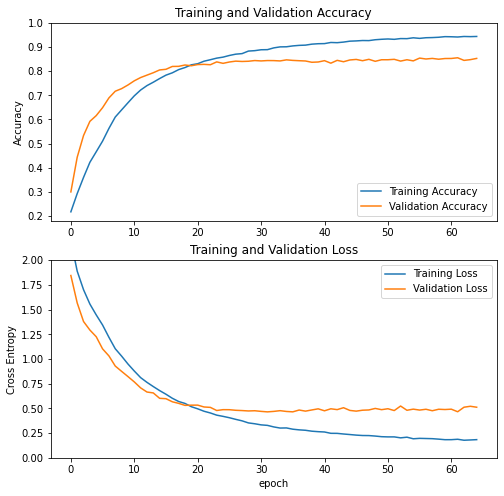

In [28]:
print(history.history.keys())
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Iterate through n_test batches and store the predicted and ground truth labels in numpy arrays.

Create and plot a confusion matrix.

In [29]:
n_test = 100 # number of batches to use
store_predictions = []
store_labels = []
for image_batch,label_batch in test_dataset.take(n_test):
    predictions = model.predict_on_batch(image_batch) 
    predictions = tf.math.argmax(predictions,axis=1)
    store_predictions.append(predictions)
    store_labels.append(label_batch)
y_pred = np.squeeze(np.reshape(store_predictions,(1,n_test*batch_size)))
y_true = np.squeeze(np.reshape(store_labels,(1,n_test*batch_size)))


Generate & print the classification report

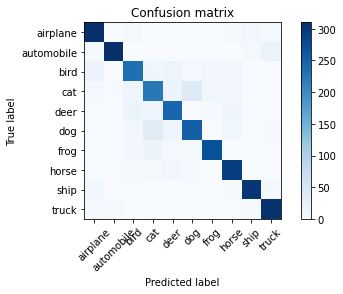

In [30]:
#https://scikit-learn.org/0.16/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(label_str))
    plt.xticks(tick_marks, label_str, rotation=45)
    plt.yticks(tick_marks, label_str)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm)

Plot some test images and predicted labels.

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=label_str))

              precision    recall  f1-score   support

    airplane       0.87      0.92      0.89       337
  automobile       0.97      0.91      0.94       338
        bird       0.80      0.76      0.78       306
         cat       0.72      0.69      0.71       323
        deer       0.80      0.82      0.81       297
         dog       0.82      0.78      0.80       325
        frog       0.90      0.88      0.89       307
       horse       0.86      0.92      0.89       317
        ship       0.93      0.93      0.93       326
       truck       0.88      0.95      0.91       324

    accuracy                           0.86      3200
   macro avg       0.86      0.86      0.86      3200
weighted avg       0.86      0.86      0.86      3200



# Please Leave a note here explaining your approach/results for the e-moderator.



(32, 10)
(32,)
Predictions:
 [7 8 6 9 5 1 7 0 3 7 7 2 7 9 2 8 8 8 7 9 4 6 3 5 0 0 2 8 1 8 6 0]


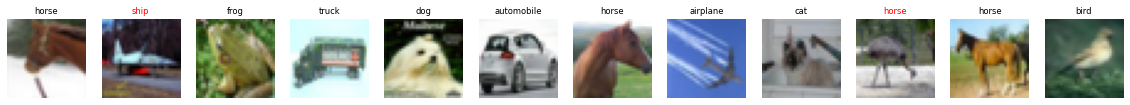

In [32]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
print(np.shape(predictions))
# Apply a sigmoid since our model returns logits
predictions = tf.math.argmax(predictions,axis=1)
print(np.shape(predictions))
print('Predictions:\n', predictions.numpy())


i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(20,10))

for image in image_batch[0:n_plots,:,:,:]:  # Only take a single example
  axarr[i].imshow(image[:,:,:]+0.5)
  axarr[i].axis('off')
  
  color = ('black' if predictions[i] == int(label_batch[i]) else 'red') 
  axarr[i].set_title(label_str[int(predictions[i])],fontsize='small', color=color)
  i = i+1

intially I was struggling to hit 80%, part of this may have been due to a low number of epochs but I did note that once I switched from average pooling to max pooling I broke the 80 mark.

I attempted to add pooling after each convolution layer, but realised it was overkill so reverted to pooling every second layer which provided a much better result

I settled on using spatial dropout in the convolution layers, and a regular dropout layer after the first dense layer.

My first model which hit 85% did so with nearly 9 million parameters, as was suggested by Tony, I reduced the model size and added data augmentation providing a slight boost in performance which brought me to 86%.

I had hoped to explore different architectures this weekend but got hit with a bad dose of the flu.